In [1]:
import os
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing_extensions import Annotated, Any

from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import ToolMessage

from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("OPENAI_API_KEY")
BASE_URL = os.getenv("BASE_URL")

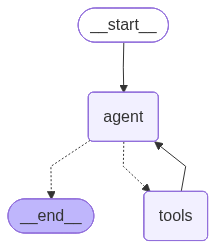

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 233, 'prompt_tokens': 172, 'total_tokens': 405, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 216, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'Qwen/Qwen3-8B', 'system_fingerprint': '', 'id': '019a3ea0424b1b5e8422cd505f057aef', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--25421072-3ff1-46c6-9fb6-a96782723016-0', tool_calls=[{'name': 'lookup_user_info', 'args': {}, 'id': '019a3ea05a3fe0392d8bf98560384402', 'type': 'tool_call'}], usage_metadata={'input_tokens': 172, 'output_tokens': 233, 'total_tokens': 405, 'input_token_details': {}, 'output_token_details': {'reasoning': 216}})]}}
{'tools': {'user_info': {'user_id': '1', 'name': 'Bob Dylan', 'location': 'New York, NY'}, 'messages': [ToolMessage(content='Use

In [2]:
USER_INFO = [ # 定义用户信息列表 (示例数据)
    {"user_id": "1", "name": "Bob Dylan", "location": "New York, NY"},
    {"user_id": "2", "name": "Taylor Swift", "location": "Beverly Hills, CA"},
]

USER_ID_TO_USER_INFO = {info["user_id"]: info for info in USER_INFO} #  用户 ID -> 用户信息 字典

class State(MessagesState): # 使用 MessagesState 而不是 AgentState
    user_info: dict[str, Any]
    user_id: str

@tool
def lookup_user_info( # 定义工具函数 lookup_user_info
    tool_call_id: Annotated[str, InjectedToolCallId],
    user_id: Annotated[str, InjectedState("user_id")]
):
    """Use this to look up user information to better assist them with their questions.""" # 工具描述信息
    if user_id is None:
        raise ValueError("Please provide user ID")
    if user_id not in USER_ID_TO_USER_INFO:
        raise ValueError(f"User '{user_id}' not found")

    user_info = USER_ID_TO_USER_INFO[user_id] # 根据 user_id 查询用户信息

    return Command( # 工具函数返回 Command 对象
        update={ # Command 对象包含状态更新指令
            "user_info": user_info, # 更新 user_info 状态键，值为查询到的用户信息
            "messages": [ # 更新 messages 状态键，添加 ToolMessage
                ToolMessage(
                    f"User information: Name is {user_info['name']}, lives in {user_info['location']}",
                    tool_call_id=tool_call_id
                )
            ],
        }
    )

# 初始化状态图
graph = StateGraph(State)

# 定义节点
def agent_node(state: State):
    """智能体节点，处理用户请求"""
    messages = state["messages"]
    user_info = state.get("user_info", {})

    # 如果有用户信息，将其添加到系统消息中
    if user_info:
        system_message = f"You are assisting {user_info['name']} who lives in {user_info['location']}."
    else:
        system_message = "You are a helpful assistant. If you need user information, call the lookup_user_info tool."

    # 调用模型处理请求
    model = ChatOpenAI(model="Qwen/Qwen3-8B", temperature=0, api_key=API_KEY, base_url=BASE_URL)
    model_with_tools = model.bind_tools([lookup_user_info])
    response = model_with_tools.invoke([{"role": "system", "content": system_message}] + messages)
    return {"messages": [response]}

def should_use_tools(state: State):
    """决定是否使用工具"""
    messages = state["messages"]
    last_message = messages[-1]

    # 检查最后一条消息是否包含工具调用
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

# 使用 ToolNode 简化工具调用逻辑
tools_node = ToolNode([lookup_user_info])

# 添加节点到图
graph.add_node("agent", agent_node)
graph.add_node("tools", tools_node)

# 添加边和条件边
graph.add_edge(START, "agent")
graph.add_edge("tools", "agent")
graph.add_conditional_edges("agent", should_use_tools, {"tools": "tools", END: END})

# 编译图
agent = graph.compile()

# 显示图
display(Image(agent.get_graph().draw_mermaid_png()))

# 调用 ReAct 智能体，通过 config 参数传递运行时参数 user_id
for chunk in agent.stream(
    # 通过 user_id 状态键传递运行时参数
    {"messages": [("human", "who am i and where do i live?")], "user_id": "1"},
):
    print(chunk)